Проанализируем ряды данных.


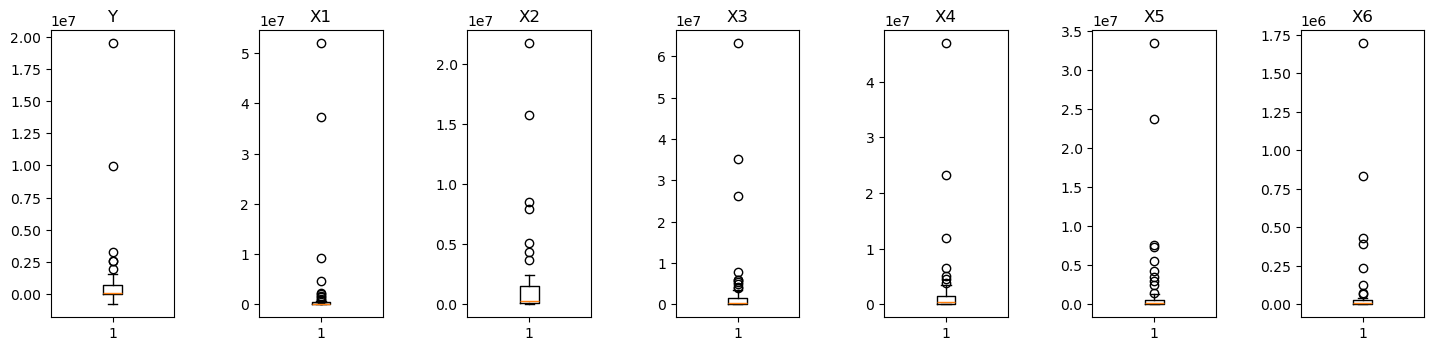

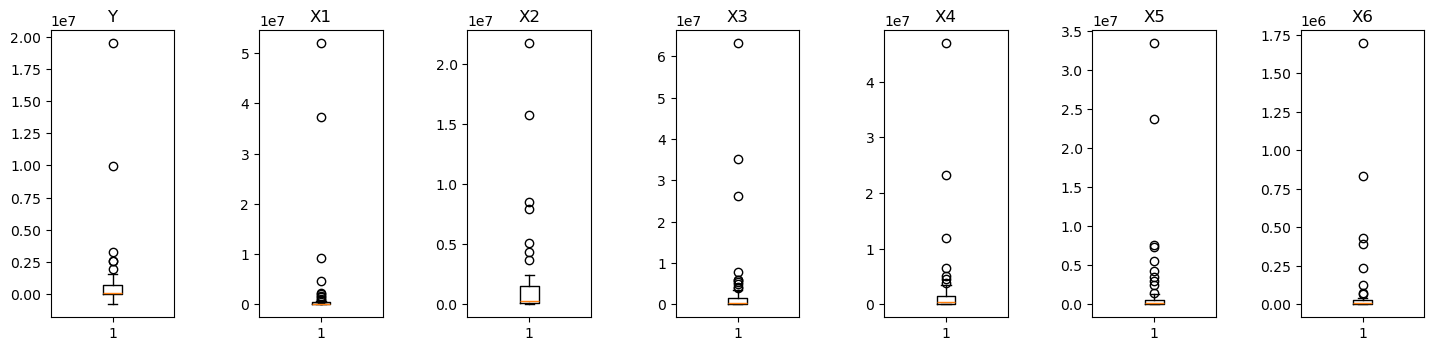

Построим диаграммы рассеяния Y с регрессорами.


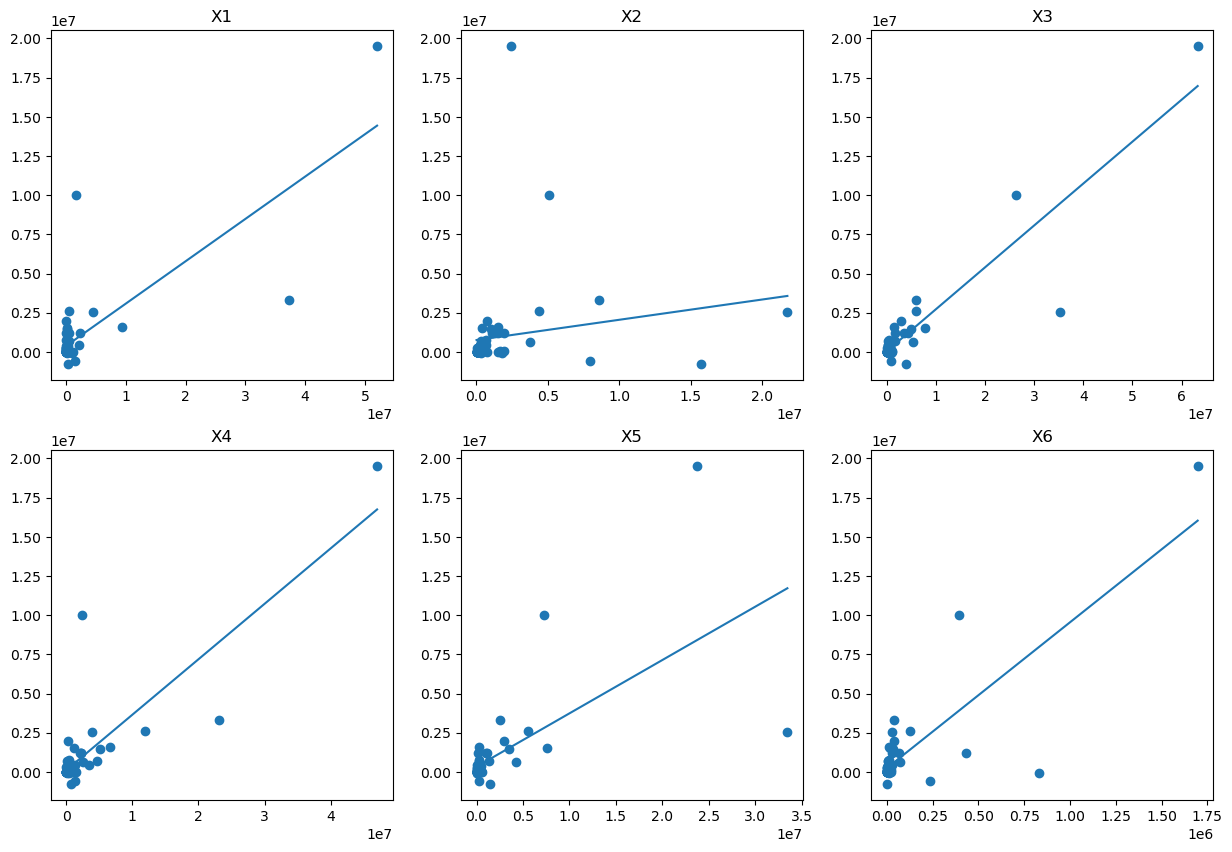

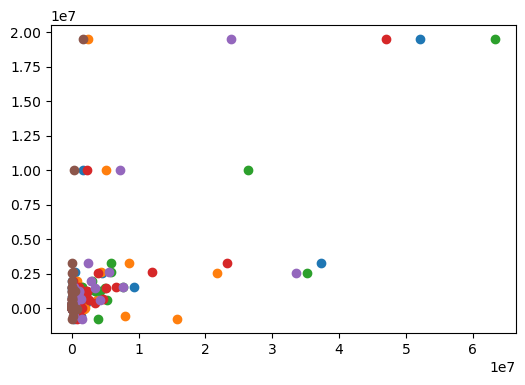

Построим корреляционную матрицу и проведем ее анализ.


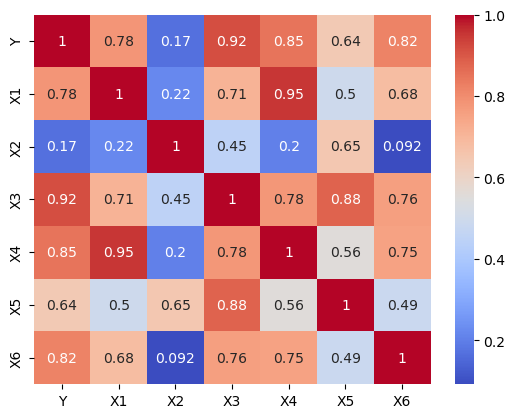

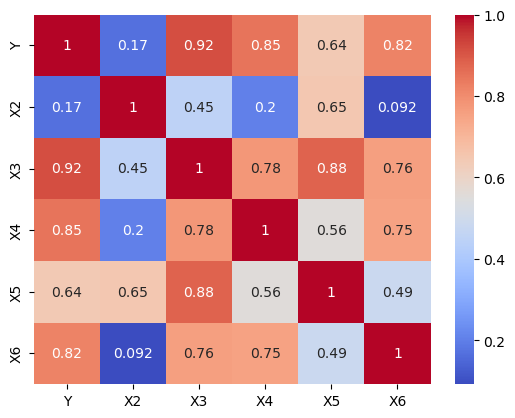

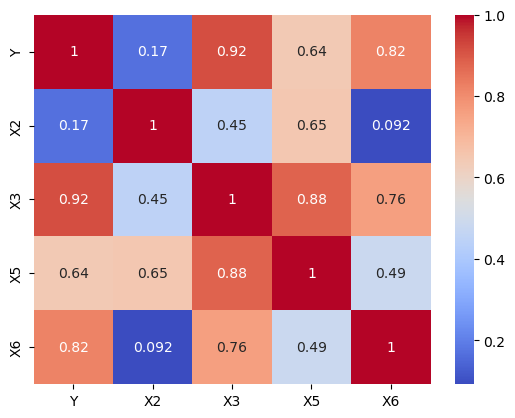

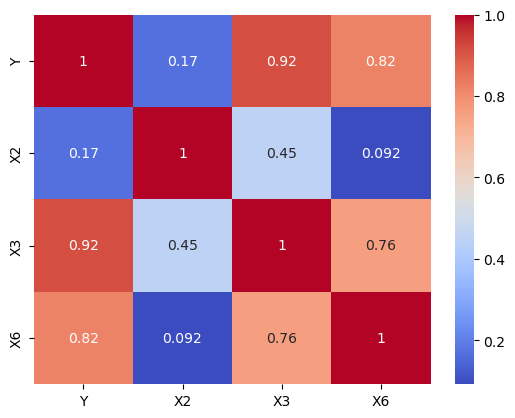

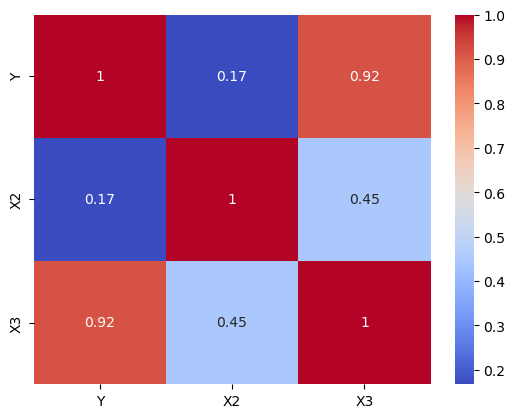

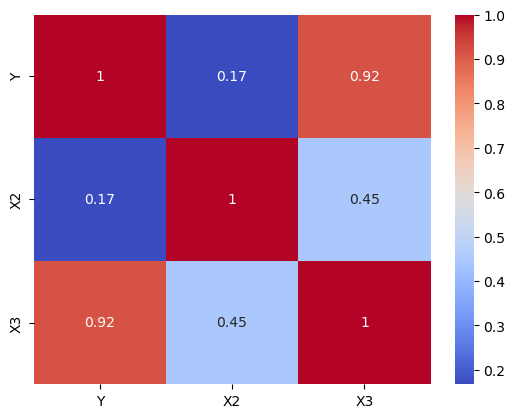

Связь между Y и X2 - ПРЯМАЯ ОЧЕНЬ СЛАБАЯ (коэффициент корреляции 0.167 - статистически не значим)

Связь между Y и X3 - ПРЯМАЯ СИЛЬНАЯ (коэффициент корреляции 0.916 - статистически значим)

Связь между X2 и X3 - ПРЯМАЯ СЛАБАЯ(коэффициент корреляции 0.448 - статистически не значим)

Построим модель со значимыми факторами. Факторы отберем методом пошагового отбора.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     263.8
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           1.27e-27
Time:                        14:12:24   Log-Likelihood:                -815.62
No. Observations:                  54   AIC:                             1637.
Df Residuals:                      51   BIC:                             1643.
Df

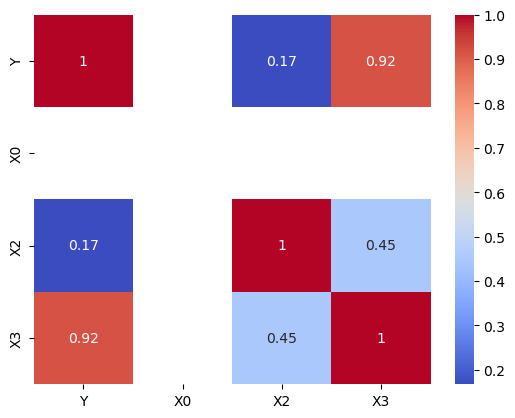

Найдем детерминант модели 0.9118563232045824.
И построим график регрессии


C:\Users\ivant\AppData\Local\Temp\ipykernel_13204\3791619156.py:296: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.p_values={self.x_col.columns[i]: self.model.pvalues[i] for i in range(0, len(self.x_col.columns))}


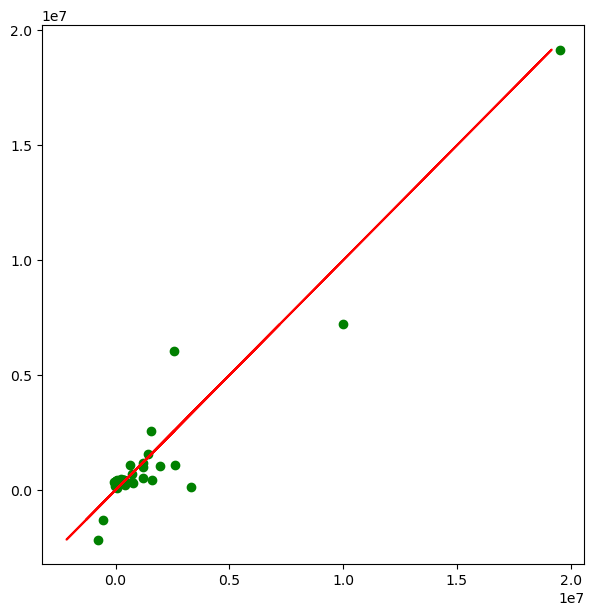

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import warnings
from pandas.errors import SettingWithCopyWarning
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

class BoxAn:
    def __init__(self,data:pd.DataFrame,from_col=0,till_col=None,y_col=0,from_col_x=1):
        self.data=data.iloc[:,from_col:till_col]
        self.prev_data=data.iloc[:,from_col:till_col]
        self.y_col=data.iloc[:,y_col]
        self.x_col=data.iloc[:,from_col_x:till_col]
    
    def get_stat_min_max(self,data_describe):
        """gets quantile delta drom pd.DataFrame.describe()

        Args:
            data_describe (pd.DataFrame): pd.DataFrame.describe()

        Returns:
            tuple: (min,max)
        """
        stat_min = data_describe['25%'] - 1.5*(data_describe['75%'] - data_describe['25%'])
        stat_max = data_describe['75%'] + 1.5*(data_describe['75%'] - data_describe['25%'])
        
        return (stat_min, stat_max)
    
    def drop_bad_data(self,data=pd.DataFrame(),y_col=0):
        if data.shape==(0,0):
            data=self.data       
            
        stat_data = data.describe()
        
        min_max = {column_name: self.get_stat_min_max(stat_data[column_name]) for column_name in data.describe().columns[y_col:]}
        
        for column_name in data.columns[y_col:]:
            median = data[np.logical_and(data[column_name] > min_max[column_name][0], data[column_name] < min_max[column_name][1])][column_name].median()

            data[column_name] = np.where(np.logical_or(data[column_name] < min_max[column_name][0], data[column_name] > min_max[column_name][1]),median,data[column_name])
        self.data=data
        return data
    
    def drop_max_y(self,data=pd.DataFrame(),y_col=0,times=5):
        if data.shape==(0,0):
            data=self.data
        name=data.columns[y_col]

        for i in range(times):
            
            data[name]=np.where(data[name]==max(data[name]),np.nan,data[name])
            
            data=data.dropna()
        self.data=data
        return data                 
        
    def remove_bad_data_x_times(self, data=pd.DataFrame(),times=1):
        if data.shape==(0,0):
            data=self.data        
            
        for i in range(times):
            data=self.drop_bad_data(data)
            
        self.data=data
        return data
    
    def boxplots(self,data=pd.DataFrame(),figsize=(15,4)):
        """Makes boxplots for every column in dataframe

        Args:
            data (pd.DataFrame)
        """
        if data.shape==(0,0):
            data=self.data  
            
        fig,ax = plt.subplots(1,data.shape[1],figsize=figsize)
        fig.tight_layout(pad=3)
        for i,j in zip(data.iloc[:,0:],ax):
            j.boxplot(data[i])
            j.set_title(i)
        plt.show()
            
    def regress_model_plot(self,X,Y,n=10_000,plotter = plt):
        
        x = np.linspace(X.min(),X.max(),n)
        b0,b1 = scipy.stats.linregress(X,Y).intercept,scipy.stats.linregress(X,Y).slope
        
        l = lambda x: b1 * x + b0
        y = [l(i) for i in x]
        plotter.plot(x,y)
        return x,y    
    
    def scatterplots(self,data=pd.DataFrame(),figsize=(15,10), lines=False,y_col=0):
        if data.shape==(0,0):
            data=self.data  
            
        shape = data.shape[1]-1
        
        dicts=dict()
        dicts2=dict()
        
        for i in range(1,shape+1):
            if shape%i==0:
                dicts[i]=shape//i
                
        for key, value in dicts.items():
            dicts2[abs(key-value)]=(key,value)
        
        shape_of_graph=dicts2[min(dicts2.keys())]
        
        fig,ax = plt.subplots(*shape_of_graph[::-1], figsize=figsize)



        for i,j in zip(data.iloc[:,y_col+1:].columns,ax.flatten()):
            j.scatter(data[i],data.iloc[:,y_col])
            j.set_title(i)
            if lines:
                self.regress_model_plot(data[i],data.iloc[:,y_col],plotter = j)
        plt.show()
    
    def scatterplot(self,data=pd.DataFrame(),figsize=(15,10),y_col=0):
        if data.shape==(0,0):
            data=self.data
        
        fig,ax = plt.subplots(figsize=figsize)
        
        for i in data.iloc[:,y_col+1:].columns:
            plt.scatter(data[i],data.iloc[:,y_col])
            
        plt.show()
    
    def corr_matrix(self,data=pd.DataFrame(),y_col=0,seaborn=True):
        
        if data.shape==(0,0):
            data=self.data
        if seaborn:
            sns.heatmap(data.iloc[:,y_col:].corr(),xticklabels=True, yticklabels=True,annot=True, cmap='coolwarm')
            plt.show()
        else:
            return 
        
    def drop_too_correlated(self,data=pd.DataFrame(),y_col=0, max_correl=0.9):
        if data.shape==(0,0):
            data=self.data
            
        cor_df=data.corr()
        k_flag=0
        for i in range(1,len(cor_df.columns)):
            for j in range(i+1,len(cor_df.columns)):
                if cor_df.iloc[i,j]>=max_correl:
                    data.pop(*cor_df[cor_df.iloc[:,y_col]==min(cor_df.iloc[y_col,i],cor_df.iloc[y_col,j])].index)
                    k_flag=1
                    break
            if k_flag==1:
                break
        self.data=data
        self.corr_matrix()
        return k_flag
        
    def drop_too_correlated_no_breaks(self,data=pd.DataFrame(),y_col=0, max_correl=0.7):
        if data.shape==(0,0):
            data=self.data
            
        cor_df=data.corr()
        k_flag=0
        for i in range(1,len(cor_df.columns)):
            for j in range(i+1,len(cor_df.columns)):
                if cor_df.iloc[i,j]>=max_correl:
                    data.pop(*cor_df[cor_df.iloc[:,y_col]==min(cor_df.iloc[y_col,i],cor_df.iloc[y_col,j])].index)

                    
        self.data=data
        self.corr_matrix()
    
    def drop_too_correlated_x_times(self,times=1,data=pd.DataFrame(),y_col=0, max_correl=0.7):
        if data.shape==(0,0):
            data=self.data
            
        for i in range(times):
            k = self.drop_too_correlated(data,y_col, max_correl)
            if k==0:
                break
            
    def drop_too_correlated_till_end(self,data=pd.DataFrame(),y_col=0, max_correl=0.7):
        if data.shape==(0,0):
            data=self.data
            
        k=1
        while k!=0:
            k = self.drop_too_correlated(data,y_col, max_correl)

            
    def corr_type(self,r)->str:
        
        ans=''
        if r > 0:
            ans += 'ПРЯМАЯ '
        elif r < 0:
                ans += 'ОБРАТНАЯ '
                
        if abs(r) == 0:
                ans += 'НЕ НАБЛЮДАЕТСЯ '
        elif abs(r) < 0.3:
                ans += 'ОЧЕНЬ СЛАБАЯ '
        elif 0.3 <= abs(r) < 0.5:
                ans += 'СЛАБАЯ'
        elif 0.5 <= abs(r) < 0.7:
                ans += 'УМЕРЕННАЯ '
        elif 0.7 <= abs(r) < 1:
                ans += 'СИЛЬНАЯ '
        else:
                ans += 'ФУНКЦИОНАЛЬНАЯ '
        return ans
    
    def t_test(self,data=pd.DataFrame,col1=0,col2=1,untrust=0.05):
        return scipy.stats.ttest_rel(data.iloc[:, col1], data.iloc[:, col2])[1] < untrust

    def define_corr(self,data=pd.DataFrame(),y_col=0,x_col=1,prin=True, do_ttest=True)->str:
        
        if data.shape==(0,0):
            data=self.data
                   
        r=data.iloc[:,x_col].corr( data.iloc[:,y_col])
        names=data.columns
        ans=self.corr_type(r)
        if do_ttest:
            if self.t_test(data,y_col,x_col):
                ans += f'(коэффициент корреляции {r:.3f} - статистически значим)'
            else:
                ans += f'(коэффициент корреляции {r:.3f} - статистически не значим)'
                
        if prin:
            print(f'Связь между {names[y_col]} и {names[x_col]} - {ans}\n')
        else:
            return ans
        
    def correlations(self,data=pd.DataFrame(),only_y=False, do_ttest=True):
    
        if data.shape==(0,0):
            data=self.data
        
        cor_df=data.corr()
        if only_y:
            for j in range(1,len(cor_df.columns)):
                self.define_corr(y_col=0,x_col=j,do_ttest=do_ttest)
        else:
            for i in range(len(cor_df.columns)):
                for j in range(i+1,len(cor_df.columns)):
                    self.define_corr(y_col=i,x_col=j,do_ttest=do_ttest)
        
    def sm_make_model(self,data=pd.DataFrame(),y_col=0):
        if data.shape==(0,0):
            data=self.data
            
        self.y_col=data.iloc[:,y_col]    
        self.x_col=pd.concat([pd.Series([1 for i in range(self.data.iloc[:,y_col+1:].shape[0])], index=self.data.iloc[:,y_col+1:].index, name='X0'), self.data.iloc[:,y_col+1:]], axis=1)
        
        self.model = sm.OLS(self.y_col.values, self.x_col.values).fit()
        return self.model.summary()
    
    def sm_get_max_p(self, data=pd.DataFrame(),untrust = 0.05, use_max=False):
        if data.shape==(0,0):
            data=self.data
        dropper=[] 
        d = {data.columns[i]: self.model.pvalues[i] for i in range(0, len(data.columns))}
        for k, v in d.items():
            if use_max:
                if v == max(d.values()) and v > untrust:
                    dropper.append(k)
            else:
                if  v > untrust:
                    dropper.append(k)
        return dropper   
    
    def sm_remove_columns(self,times=1,data=pd.DataFrame(),y_col=0):
        if data.shape==(0,0):
            data=self.data
            
        list_on_drop = []
        
        list_on_drop.extend(self.sm_get_max_p(self.x_col))
        self.x_col=self.x_col.drop(list_on_drop, axis=1)
        
        if all([self.x_col.shape[i]!=0 for i in range(len(self.x_col.shape))]) and all([self.y_col.shape[i]!=0 for i in range(len(self.y_col.shape))]):
            
            
            self.data=pd.concat([self.y_col,self.x_col],axis=1)
            self.model = sm.OLS(self.y_col, self.x_col.values).fit()
            self.corr_matrix()    
            self.p_values={self.x_col.columns[i]: self.model.pvalues[i] for i in range(0, len(self.x_col.columns))}
        
    def sl_make_model(self,data=pd.DataFrame(),y_col=0):
        if data.shape==(0,0):
            data=self.data
        self.lin_model = LinearRegression().fit(self.data.iloc[:,y_col+1:],self.data.iloc[:,y_col])
        return self.lin_model.score(self.data.iloc[:,y_col+1:],self.data.iloc[:,y_col])
    
    def sl_plot(self,data=pd.DataFrame(),y_col=0, only_y=True):
        if data.shape==(0,0):
            data=self.data       
        fig,ax = plt.subplots(1,figsize=(7,7))
        
        y_ = self.lin_model.predict(self.data.iloc[:,y_col+1:])
        
        if not(only_y):
            for i in range(1,len(data.columns)):
                ax.scatter(data.iloc[:,y_col],data.iloc[:,i])

        ax.scatter(data.iloc[:,y_col],y_, color='green')
        ax.plot(y_,y_,c='r')
        plt.show()
        
    def complex_analysis(self,drop_y=0, replace_to_median=0):
        print('Проанализируем ряды данных.')
        self.boxplots()
        t=''
        if drop_y:
            t+=f'Удалим {drop_y} верхних значений Y'
            self.drop_max_y(times=drop_y)
        if replace_to_median:
            t+=f'''
С помощью квартильного размаха проведем удаление выбросов.

Проведем эту операцию {replace_to_median} раз

Данные можно сократить, т.к. существуют внешние факторы, не входящие в модель.
            '''
            self.remove_bad_data_x_times(times=replace_to_median)
            
        self.boxplots()
        
        print('Построим диаграммы рассеяния Y с регрессорами.')
        self.scatterplots(lines=True)
        self.scatterplot(figsize=(6,4))
        
        print('Построим корреляционную матрицу и проведем ее анализ.')
        self.corr_matrix()
        self.drop_too_correlated_till_end()
        self.correlations()
        
        print('Построим модель со значимыми факторами. Факторы отберем методом пошагового отбора.')
        print(self.sm_make_model())
        
        print('С помощью отбор по P-велечине уберем часть столбцов')
        self.sm_remove_columns(times=1)
        
        print(f'Найдем детерминант модели {self.sl_make_model()}.\nИ построим график регрессии')
        self.sl_plot()
        
        
        
df = pd.read_excel('Домашнее задание №2 ММР.xlsx', header=1,index_col=0, usecols=[1,2,3,4,5,6,7,8])
df.columns=['Y', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6']

analysys = BoxAn(df)
analysys.complex_analysis()